In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
from qutip import *

In [3]:
class SystemParameters:
    
    def __init__(self):
        # Input variable
        
        self.init_system()
        self.init_operators()
        self.state_operators()
        
    def init_system(self):
        self.initial_pulse = True
        self.qubit_state_num = 3
        self.alpha = 0.224574
        self.freq_ge = 3.9225 #GHz
        self.ens = np.array([ 2*np.pi*ii*(self.freq_ge - 0.5*(ii-1)*self.alpha) for ii in np.arange(self.qubit_state_num)])
        
        self.mode_state_num = 3
        
        self.qm_g1 = 2*np.pi*0.075 #GHz
        self.mode1_freq = 6.11 #GHz
        self.mode1_ens = np.array([ 2*np.pi*ii*(self.mode1_freq) for ii in np.arange(self.mode_state_num)])
        
        self.qm_g2 = 2*np.pi*0.075 #GHz
        self.mode2_freq = 6.65 #GHz
        self.mode2_ens = np.array([ 2*np.pi*ii*(self.mode2_freq) for ii in np.arange(self.mode_state_num)])
        
        self.state_num = self.qubit_state_num * (self.mode_state_num**2)
        
        self.pts_per_period = 40
        self.dt = (1./self.mode2_freq)/self.pts_per_period
        self.total_time=200.
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def update_total_time(self,total_time):
        self.total_time=total_time
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def update_pts_per_period(self,pts_per_period):
        self.pts_per_period=pts_per_period
        self.dt = (1./self.mode_freq)/self.pts_per_period
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def init_operators(self):
        # Create operator matrix in numpy array
        H_q = np.diag(self.ens)
        H_m1 = np.diag(self.mode1_ens)
        H_m2 = np.diag(self.mode2_ens)
        
        Q_x   = np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),-1)
        Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),-1))
        Q_z   = np.diag(np.arange(0,self.qubit_state_num))
        
        M_x = np.diag(np.sqrt(np.arange(1,self.mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,self.mode_state_num)),-1)
        
        self.I_q = np.identity(self.qubit_state_num)
        self.I_m = np.identity(self.mode_state_num)
        
        XI = np.kron(Q_x,np.kron(self.I_m,self.I_m))
        YI = np.kron(Q_y,np.kron(self.I_m,self.I_m))
        ZI = np.kron(Q_z,np.kron(self.I_m,self.I_m))
        
        self.ops = [XI,YI,ZI]
        
        self.Hx_op = XI
        self.Hy_op = YI
        self.Hz_op = ZI
        
        self.ops_len = len(self.ops)
        
        self.H0 = np.kron(H_q,np.kron(self.I_m,self.I_m)) + np.kron(self.I_q,np.kron(H_m1,self.I_m)) +\
            np.kron(self.I_q,np.kron(self.I_m,H_m2)) + self.qm_g1*np.kron(Q_x,np.kron(M_x,self.I_m)) +\
            self.qm_g2*np.kron(Q_x,np.kron(self.I_m,M_x))
       
    def state_operators(self):
        # State operators, used for output
        g_array= np.zeros(self.qubit_state_num)
        g_array[0] = 1
        g_vector = tensor(Qobj(np.array(g_array)),Qobj(self.I_m),Qobj(self.I_m))
        g_matrix = tensor(Qobj(np.diag(g_array)),Qobj(self.I_m),Qobj(self.I_m))

        e_array= np.zeros(self.qubit_state_num)
        e_array[1] = 1
        e_vector = tensor(Qobj(np.array(e_array)),Qobj(self.I_m),Qobj(self.I_m))
        e_matrix = tensor(Qobj(np.diag(e_array)),Qobj(self.I_m),Qobj(self.I_m))

        f_array= np.zeros(self.qubit_state_num)
        f_array[2] = 1
        f_vector = tensor(Qobj(np.array(f_array)),Qobj(self.I_m),Qobj(self.I_m))
        f_matrix = tensor(Qobj(np.diag(f_array)),Qobj(self.I_m),Qobj(self.I_m))
        
        
        H0 = Qobj(self.H0)
        
        self.g00 = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag()
        self.e00 = H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag()
        self.g10 = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag()
        self.g01 = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag()
        self.f00 = H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag()
        self.e10 = H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag()
        self.e01 = H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag()
        self.g11 = H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag()

        
        self.gs = g_vector
        self.es = e_vector
        self.fs = f_vector

        return [self.g00,self.e00,self.g10,self.g01,self.f00,self.e10,self.e01,self.g11]
    
    
    def c_operators(self):
        # qubit coherence parameters

        T1_ge = 18000.0
        T1_ef = 7000.0
        T2_ge = 12000.0
        T2_ef = 12000.0
        T_ephi = 1/(1/T2_ge -1/(2*T1_ge))
        T_fphi = 1/(1/T2_ef -1/(2*T1_ef))
        
        # cavity coherence_parameters
        T1_cav1 = 4000.0
        T1_cav2 = 4000.0
        kappa1 = 1/T1_cav1 # cavity dissipation rate
        kappa2 = 1/T1_cav2 # cavity dissipation rate
        
        a1  = tensor(qeye(self.qubit_state_num),destroy(self.mode_state_num),qeye(self.mode_state_num))
        a2  = tensor(qeye(self.qubit_state_num),qeye(self.mode_state_num),destroy(self.mode_state_num))

        c_ops = (1/T1_ge)*lindblad_dissipator(self.gs*self.es.dag()) +   (1/T1_ef)*lindblad_dissipator(self.es*self.fs.dag()) +\
        (2/(T_ephi))*lindblad_dissipator(self.es*self.es.dag()) + (2/(T_fphi))*lindblad_dissipator(self.fs*self.fs.dag()) +\
        + (1/(T1_cav1))*lindblad_dissipator(a1)+ (1/(T1_cav2))*lindblad_dissipator(a2)
        
        return c_ops
    
    def time_to_index(self,time):
        return int(time/self.dt - 1)

In [4]:
sys_para = SystemParameters()
print Qobj(sys_para.H0).eigenstates()[0]/(2*np.pi)

[ -1.09333835e-03   3.91563935e+00   6.11090738e+00   6.65044011e+00
   7.61195747e+00   1.00271505e+01   1.05668412e+01   1.22245836e+01
   1.27624404e+01   1.33035656e+01   1.37184640e+01   1.42592779e+01
   1.61497520e+01   1.66783416e+01   1.72274496e+01   1.88761038e+01
   1.94155887e+01   1.98388814e+01   2.03657972e+01   2.09179817e+01
   2.28009216e+01   2.33389468e+01   2.55292597e+01   2.64861502e+01
   2.70245446e+01   2.94615449e+01   3.31448963e+01]


In [24]:
class H_Pulse:
    def __init__(self, sys_para):
        self.sys_para = sys_para
        self.tlist = self.sys_para.tlist
        self.pulse_coeff_array = np.zeros(len(self.tlist))
        
    def gauss_span_length(self,length):
        spacing = 5
        return 4*length + spacing

    def square_span_length(self,length):
        spacing = 5
        ramp_sigma = 10
        return length + 4*ramp_sigma + spacing

    def gauss(self,tlist,time,amp,freq,length,phase):
        span_length = self.gauss_span_length(length)
        t0 = time+0.5*span_length
        return amp*np.exp(-(tlist-t0)**2/(2*length**2)) * (tlist>time) * (tlist< (time+span_length)) *\
        np.sin(2*np.pi*freq*tlist + phase)
        
    def square(self,tlist,time,amp,freq,length,phase):
        ramp_sigma = 10
        span_length = self.gauss_span_length(length)
        t0 = time+2*ramp_sigma
        pulse = amp*np.exp(-(tlist-t0)**2/(2*ramp_sigma**2)) * (tlist>time) * (tlist<= t0) *\
        np.sin(2*np.pi*freq*tlist + phase)
        pulse = pulse + amp*(tlist>t0) * (tlist<= (t0+length)) * np.sin(2*np.pi*freq*tlist  +phase)
        pulse = pulse + amp*np.exp(-(tlist-(t0+length))**2/(2*ramp_sigma**2)) * (tlist>t0+length) * (tlist<= t0+length+2*ramp_sigma) *\
        np.sin(2*np.pi*freq*tlist +phase)
        
        return pulse
        
    def add_pulse(self,time,amp,freq,length,phase,ptype):
        if ptype == "gauss":
            self.pulse_coeff_array += self.gauss(self.tlist,time,amp,freq,length,phase)
            return time + self.gauss_span_length(length)
        elif ptype == "square":
            self.pulse_coeff_array += self.square(self.tlist,time,amp,freq,length,phase)
            return time + self.square_span_length(length)
        
    def add_defined_pulse(self,time,pulse):
        return self.add_pulse(time,pulse.amp,pulse.freq,pulse.length,pulse.phase,pulse.ptype)
    
    def add_arb_pulse(self,arb_pulse):
        c = self.pulse_coeff_array.copy()
        c[:len(arb_pulse)] += arb_pulse
        self.pulse_coeff_array = c
        
    def get_coeff(self,time):
        index = self.sys_para.time_to_index(time)
        return self.pulse_coeff_array[index]
    
    

In [6]:
def plot_result(output,sys_para):
    # Plotting
    # [self.g00,self.e00,self.g10,self.g01,self.e10,self.e01,self.g11]
    g00_out = output.expect[0]
    e00_out= output.expect[1]
    g10_out = output.expect[2]
    g01_out = output.expect[3]
    f00_out = output.expect[4]
    e10_out = output.expect[5]
    e01_out = output.expect[6]
    g11_out = output.expect[7]
    

    fig, axes = plt.subplots(1, 1, figsize=(10,6))

    axes.plot(sys_para.tlist, g00_out, label="g00")
    axes.plot(sys_para.tlist, e00_out, label="e00")
    axes.plot(sys_para.tlist, g10_out, label="g10")
    axes.plot(sys_para.tlist, g01_out, label="g01")
    axes.plot(sys_para.tlist, f00_out, label="f00")
    axes.plot(sys_para.tlist, e10_out, label="e10")
    axes.plot(sys_para.tlist, e01_out, label="e01")
    axes.plot(sys_para.tlist, g11_out, label="g11")
    axes.legend(loc=0)
    axes.set_xlabel('Time')
    axes.set_ylabel('Occupation probability')

In [7]:
def plot_sweep_result(p_g,p_e,tlist,sweep):
    plt.figure(figsize=(20,8))

    plt.subplot(121, title="g")

    plt.pcolormesh(tlist,sweep, np.array(p_g))
    plt.xlabel('Time')

    plt.subplot(122, title="e")

    plt.pcolormesh(tlist,sweep, np.array(p_e))
    plt.xlabel('Time')

In [18]:
class Pulse:
    def __init__(self,amp,freq,length,phase,ptype):
        self.amp = amp
        self.freq = freq
        self.length = length
        self.phase = phase
        self.ptype = ptype

### Info

In [32]:
pi_length = 24.2
pi_amp = 0.0542
ef_pi_length = 9.4
ef_pi_amp = 0.099

sb1_pi_length = 24.
sb1_pi_amp = 2*np.pi*0.307
sb1_2pi_length = 90.
sb1_2pi_amp = 2*np.pi*0.26
sb1_ef_pi_length = 26.5
sb1_ef_pi_amp = 2*np.pi*0.227
sb1_ef_2pi_length = 75.
sb1_ef_2pi_amp = 2*np.pi*0.231

sb2_pi_length = 17.
sb2_pi_amp = 2*np.pi*0.445
sb2_2pi_length = 58.
sb2_2pi_amp = 2*np.pi*0.445
sb2_ef_pi_length = 75
sb2_ef_pi_amp = 2*np.pi*0.14
sb2_ef_2pi_length = 177.
sb2_ef_2pi_amp = 2*np.pi*0.137

In [48]:
H0 = Qobj(sys_para.H0)
drive_freq =  (H0.eigenstates()[0][1] - H0.eigenstates()[0][0])/(2*np.pi)
flux_freq1 = (H0.eigenstates()[0][2] - H0.eigenstates()[0][1])/(2*np.pi)
flux_freq2 = (H0.eigenstates()[0][3] - H0.eigenstates()[0][1])/(2*np.pi)
ef_flux_freq1 = (H0.eigenstates()[0][5] - H0.eigenstates()[0][4])/(2*np.pi)
ef_flux_freq2 = (H0.eigenstates()[0][6] - H0.eigenstates()[0][4])/(2*np.pi)
    
ge_pi_pulse = Pulse(pi_amp,drive_freq,pi_length,0,"gauss")
ge_half_pi_pulse = Pulse(pi_amp,drive_freq,pi_length/2,0,"gauss")

sb1_pi_pulse = Pulse(sb1_pi_amp,flux_freq1,sb1_pi_length,0,"square")
sb1_2pi_pulse = Pulse(sb1_2pi_amp,flux_freq1,sb1_2pi_length,0,"square")
sb2_pi_pulse = Pulse(sb2_pi_amp,flux_freq2,sb2_pi_length,0,"square")
sb2_2pi_pulse = Pulse(sb2_2pi_amp,flux_freq2,sb2_2pi_length,0,"square")
sb1_ef_pi_pulse = Pulse(sb1_ef_pi_amp,ef_flux_freq1,sb1_ef_pi_length,0,"square")
sb1_ef_2pi_pulse = Pulse(sb1_ef_2pi_amp,ef_flux_freq1,sb1_ef_2pi_length,0,"square")
sb2_ef_pi_pulse = Pulse(sb2_ef_pi_amp,ef_flux_freq2,sb2_ef_pi_length,0,"square")
sb2_ef_2pi_pulse = Pulse(sb2_ef_2pi_amp,ef_flux_freq2,sb2_ef_2pi_length,0,"square")


### Ramsey Test

In [49]:
def Ramsey_test(sys_para, sweep = False, amp = 0.0):
    # Define pulses
    Hx_pulse = H_Pulse(sys_para)
    Hy_pulse = H_Pulse(sys_para)
    Hz_pulse = H_Pulse(sys_para)
    
    
    
    if not sweep:
        time = Hx_pulse.add_defined_pulse(time=0,pulse=ge_half_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        
        print time
    else:
        Hz_pulse.add_pulse(time=0,amp=2*np.pi*amp,freq=ef_flux_freq2/(2*np.pi),length=sb2_ef_2pi_length,phase=0,ptype="square")
        
        
    if not sweep:
        fig, axes = plt.subplots(1, 1, figsize=(10,6))
        plt.plot(sys_para.tlist,Hx_pulse.pulse_coeff_array)
        plt.plot(sys_para.tlist,Hy_pulse.pulse_coeff_array)
        plt.plot(sys_para.tlist,Hz_pulse.pulse_coeff_array)
        axes.set_title('Input Pulse')

    # Get Hamiltonian pulse value at time t
    def Hx_coeff(t,args=None):
        Hx_t = Hx_pulse.get_coeff(t)
        return Hx_t

    def Hy_coeff(t,args=None):
        Hy_t = Hy_pulse.get_coeff(t)
        return Hy_t
    
    def Hz_coeff(t,args=None):
        Hz_t = Hz_pulse.get_coeff(t)
        return Hz_t

    # Hamiltonian
    H0 = Qobj(sys_para.H0)
    Hx = Qobj(sys_para.Hx_op)
    Hy = Qobj(sys_para.Hy_op)
    Hz = Qobj(sys_para.Hz_op)
    H_t = [H0, [Hx,Hx_coeff], [Hy,Hy_coeff],[Hz,Hz_coeff]]
    
    state_ops = sys_para.state_operators()
    c_ops = sys_para.c_operators()

    # Run Simulation
    if True:
        psi0 = state_ops[0] # start in ground cavity and excited transmon
        output = mesolve(H_t, psi0, sys_para.tlist, c_ops, state_ops ,progress_bar=True)
        clear_output()

        if not sweep:
            plot_result(output,sys_para)
        fidelity = output.expect[0][sys_para.steps-1]

        return (output,fidelity)

In [ ]:
sys_para = SystemParameters()
sys_para.update_total_time(200)
Ramsey_test(sys_para)

### CPhase test

In [46]:
def CPhase_test(sys_para, sweep = False, amp = 0.0):
    # Define pulses
    Hx_pulse = H_Pulse(sys_para)
    Hy_pulse = H_Pulse(sys_para)
    Hz_pulse = H_Pulse(sys_para)
    
    
    
    if not sweep:
        time = Hx_pulse.add_defined_pulse(time=0,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_ef_2pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=0,pulse=ge_pi_pulse)
        
        print time
    else:
        Hz_pulse.add_pulse(time=0,amp=2*np.pi*amp,freq=ef_flux_freq2/(2*np.pi),length=sb2_ef_2pi_length,phase=0,ptype="square")
        
        
    if not sweep:
        fig, axes = plt.subplots(1, 1, figsize=(10,6))
        plt.plot(sys_para.tlist,Hx_pulse.pulse_coeff_array)
        plt.plot(sys_para.tlist,Hy_pulse.pulse_coeff_array)
        plt.plot(sys_para.tlist,Hz_pulse.pulse_coeff_array)
        axes.set_title('Input Pulse')

    # Get Hamiltonian pulse value at time t
    def Hx_coeff(t,args=None):
        Hx_t = Hx_pulse.get_coeff(t)
        return Hx_t

    def Hy_coeff(t,args=None):
        Hy_t = Hy_pulse.get_coeff(t)
        return Hy_t
    
    def Hz_coeff(t,args=None):
        Hz_t = Hz_pulse.get_coeff(t)
        return Hz_t

    # Hamiltonian
    H0 = Qobj(sys_para.H0)
    Hx = Qobj(sys_para.Hx_op)
    Hy = Qobj(sys_para.Hy_op)
    Hz = Qobj(sys_para.Hz_op)
    H_t = [H0, [Hx,Hx_coeff], [Hy,Hy_coeff],[Hz,Hz_coeff]]
    
    state_ops = sys_para.state_operators()
    c_ops = sys_para.c_operators()

    # Run Simulation
    if True:
        psi0 = state_ops[0] # start in ground cavity and excited transmon
        output = mesolve(H_t, psi0, sys_para.tlist, c_ops, state_ops ,progress_bar=True)
        clear_output()

        if not sweep:
            plot_result(output,sys_para)
        fidelity = output.expect[0][sys_para.steps-1]

        return (output,fidelity)

(Result object with mesolve data.
 --------------------------------
 expect = True
 num_expect = 8, num_collapse = 0, 0.011983620528203452)

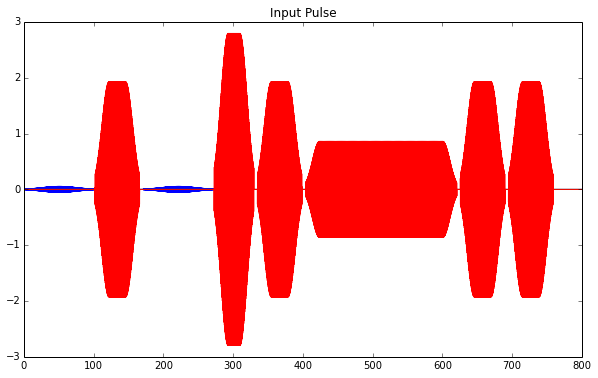

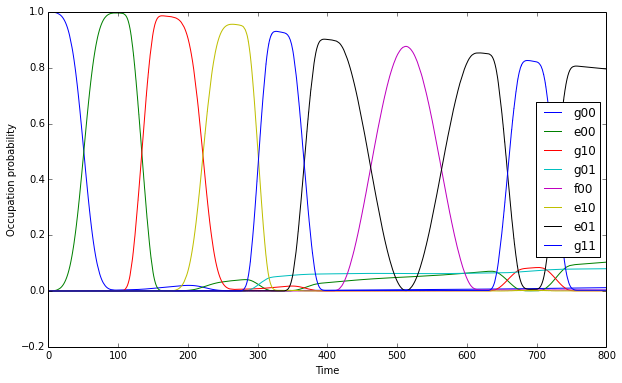

In [47]:
sys_para = SystemParameters()
sys_para.update_total_time(800)
CPhase_test(sys_para)